# Getting started
* To install PyTorch. Follow the steps in [this](https://pytorch.org/get-started/locally/) link
* see [here](https://pypi.org/project/split-folders/) for more information on the splitfolders package used in 'helper'
* general example to follow: see [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), [here](https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db), or [here](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)

In [1]:
%matplotlib inline

In [2]:
# pytorch stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [3]:
# custom imports
from helper import InstagramDataset, data_labeler, ResNet

# Labeling

In [18]:
bins = 10

bins created


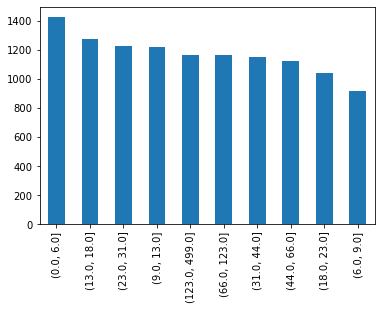

target directories created at: recipes_labeled
Splitting and labeling done. Results can be found at: recipes_labeled_splitted


In [19]:
# note that splitting the data into split, val, test and reorganizing folders accordingly is a slow process
# this operation can take up to 15-30min. Check the function to get an idea what is going on in the background
data_labeler(target_dir='recipes_labeled', source_dir='recipes/recipes/', bins=bins,
             target_name='likes', metadata_path='recipes.csv', sep=';')

# Reading Instadata following PyTorch convention

In [20]:
# here we load the Instagram dataset through a custom class, this class reads the data, applies transformations,
# and creates batches for train, test, and val data as iterators (i.e. dataloaders)
# see docstring for further information
insta_data = InstagramDataset('recipes_labeled_splitted')
dataloaders = insta_data.dataloaders

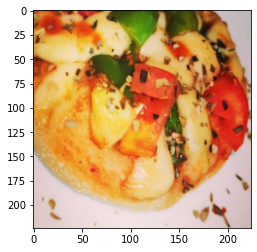

In [21]:
# check random image, works especially well if you're hungry... :)
insta_data.imshow(15)

# The model

In [22]:
resn = ResNet(dataloaders, insta_data.dataset_sizes, pretrained=True) #initialize the ResNet defined in helper
model = resn.model

In [23]:
model.eval() #the original resnet 50 structure

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# extract number of nodes in last fc layer and add own fc layer
num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, bins) # from 2048 to 10 (i.e. our target)
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, bins),
    nn.Softmax(dim=1))
model = model.to(resn.device)

# set objective criterion
criterion = nn.CrossEntropyLoss()

# Observe that only params in last fc layer are optimized
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [16]:
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, bins),
    nn.Softmax(dim=1))

In [25]:
# observe how the last layer has been replaced by our own layer
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
resn.train_model(criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 2.3027 Acc: 0.1042
val Loss: 2.3016 Acc: 0.1202

Training complete in 43m 33s
Best val Acc: 0.120172


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 